In [1]:
%matplotlib inline
import math
import torch 
from torch import nn
from torch.nn import functional as F 
from d2l import torch as d2l
from sklearn.model_selection import ParameterGrid

In [2]:
class RNNScratch(d2l.Module):   #@save
    """The RNN model implemented from scratch."""
    def __init__(self,num_inputs,num_hiddens,sigma=0.01): #sigma is the standard deviation of the disbn from which the parameters are initialized
        super().__init__()
        self.save_hyperparameters()
        self.W_xh = nn.Parameter(
                                torch.randn(num_inputs,num_hiddens)*sigma)
        self.W_hh = nn.Parameter(
                                torch.randn(num_hiddens,num_hiddens)*sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))

In [3]:
# we train on multiple sequences at once using batching
@d2l.add_to_class(RNNScratch) #@save
def forward(self,inputs,state=None): # inputs shape is (num_steps, batch_size, num_inputs)
    if state is None:
        # Initial state with shape: (batch_size, num_hiddens)
        state = torch.zeros((inputs.shape[1],self.num_hiddens),
                            device = inputs.device)
    else:
        state, = state #unpacks state and assigns its only element to state again
    outputs = []
    for X in inputs: # inputs shape is (batch_size, num_inputs)
        state = torch.tanh(torch.matmul(X, self.W_xh) +
                         torch.matmul(state, self.W_hh) + self.b_h)
        outputs.append(state)
    return outputs,state # outputs is the hidden states for each time step

In [4]:
batch_size, num_inputs, num_hiddens, num_steps = 2, 16, 32, 100
rnn = RNNScratch(num_inputs, num_hiddens)
X = torch.ones((num_steps, batch_size, num_inputs))
outputs, state = rnn(X)

In [5]:
class RNNLMScratch(d2l.Classifier):  #@save
    """The RNN-based language model implemented from scratch."""
    def __init__(self, rnn, vocab_size, lr=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.init_params()

    def init_params(self):
        self.W_hq = nn.Parameter(
            torch.randn(
                self.rnn.num_hiddens, self.vocab_size) * self.rnn.sigma)
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=False)

In [6]:
#using one-hot encoding each minibatch will have batch_size no. of sequences, each having num_steps no of tokens, and each token represented by a vector of vocab_size
#therefore the shape of the minibatch becomes(num_steps, batch_size, vocab_size)
@d2l.add_to_class(RNNLMScratch)  #@save
def one_hot(self, X):
    # Output shape: (num_steps, batch_size, vocab_size)
    return F.one_hot(X.T, self.vocab_size).type(torch.float32)

In [7]:
@d2l.add_to_class(RNNLMScratch)  #@save
def output_layer(self, rnn_outputs):
    outputs = [torch.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]
    return torch.stack(outputs, 1) # stacks all time steps along the dimension 1 final shape being (batch_size,num_steps,vocab_size)

@d2l.add_to_class(RNNLMScratch)  #@save
def forward(self, X, state=None):
    embs = self.one_hot(X)
    rnn_outputs, _ = self.rnn(embs, state)
    return self.output_layer(rnn_outputs)

In [8]:
@d2l.add_to_class(d2l.Trainer) #@save
def clip_gradients(self,grad_clip_val,model):
    params = [p for p in model.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum(p.grad**2) for p in params))
    if norm > grad_clip_val:
        for param in params:
            param.grad[:] *= grad_clip_val/norm

In [9]:
data = d2l.TimeMachine(batch_size = 1024,num_steps = 32)
rnn = RNNScratch(num_inputs = len(data.vocab),num_hiddens=32)
model = RNNLMScratch(rnn,vocab_size = len(data.vocab),lr = 1)
trainer = d2l.Trainer(max_epochs = 100,gradient_clip_val = 1, num_gpus = 0)
#trainer.fit(model,data)

In [10]:
@d2l.add_to_class(RNNLMScratch)  #@save
def predict(self, prefix, num_preds, vocab, device=None):
    state, outputs = None, [vocab[prefix[0]]]
    for i in range(len(prefix) + num_preds - 1):
        X = torch.tensor([[outputs[-1]]], device=device)
        embs = self.one_hot(X)
        rnn_outputs, state = self.rnn(embs, state)
        if i < len(prefix) - 1:  # Warm-up period
            outputs.append(vocab[prefix[i + 1]])
        else:  # Predict num_preds steps
            Y = self.output_layer(rnn_outputs)
            outputs.append(int(Y.argmax(axis=2).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [11]:
model.predict('it has', 30, data.vocab, d2l.try_gpu())

'it hasmvfzl uxyvfzl uxyvfzl uxyvfzl '

In [12]:
def experiment(num_steps,num_hiddens,lr):
    data = d2l.TimeMachine(batch_size = 1024,num_steps=num_steps)
    rnn = RNNScratch(num_inputs=len(data.vocab),num_hiddens=num_hiddens)
    model = RNNLMScratch(rnn,vocab_size=len(data.vocab), lr=lr)
    trainer = d2l.Trainer(max_epochs = 100,gradient_clip_val=1)
    trainer.fit(model,data)
    X,y = next(iter(data.get_dataloader(False)))
    y_hat = model(X)
    return torch.exp(model.loss(y_hat,y))

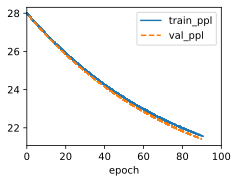

In [ ]:
param_grid = {'num_steps':[8,16,32,64,128],
              'num_hiddens':[8,16,32,64,128],
              'lr':[0.01,0.1,1,10,100]}
param_grid_obj = ParameterGrid(param_grid)
ppls = []
for params in param_grid_obj:
    ppl = experiment(**params)
    ppls.append(ppl)
    print(params,ppl)

In [ ]:
class EmbRNNLMScratch(d2l.Classifier):  #@save
    """The RNN-based language model implemented from scratch."""
    def __init__(self, rnn, vocab_size, lr=0.01, plot_flag=True, emb_len=8):
        super().__init__()
        self.save_hyperparameters()
        self.init_params()

    def init_params(self):
        self.W_hq = nn.Parameter(
            torch.randn(
                self.rnn.num_hiddens, self.emb_len) * self.rnn.sigma)
        self.b_q = nn.Parameter(torch.zeros(self.emb_len))
        self.lembs = nn.Parameter(torch.randn(self.vocab_size, self.emb_len))

    def forward(self, X, state=None):
        embs = torch.matmul(self.one_hot(X).float(),self.lembs)
        rnn_outputs, _ = self.rnn(embs, state)
        return self.output_layer(rnn_outputs)
    
    def training_step(self, batch, plot_flag=True):
        l = self.loss(self(*batch[:-1]), batch[-1])
        if plot_flag:
            self.plot('ppl', torch.exp(l), train=True)
        return l

    def validation_step(self, batch, plot_flag=True):
        l = self.loss(self(*batch[:-1]), batch[-1])
        if plot_flag:
            self.plot('ppl', torch.exp(l), train=False)
        return l
        
    def one_hot(self, X):
        # Output shape: (num_steps, batch_size, vocab_size)
        return F.one_hot(X.T, self.vocab_size).type(torch.float32)
    
    def output_layer(self, rnn_outputs):
        outputs = [torch.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]
        return torch.stack(outputs, 1)

An embedding matrix is a learnable table of vector representations for tokens (like words or characters) in your vocabulary
shape of the matrix is (vocab_size, embedding_dim)
Each row corresponds to one token
it helps in catching semantic relationships between words as similar words have similar embedding vetors

In [ ]:
emb_len=len(data.vocab)
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNNScratch(num_inputs=emb_len, num_hiddens=32)
model = EmbRNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1, emb_len=emb_len)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1) #, num_gpus=1
trainer.fit(model, data)
X,y = next(iter(data.get_dataloader(False)))
y_hat = model(X) 
torch.exp(model.loss(y_hat,y)).item()